In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from models import *

In [2]:
NE = 600
Ds_pert = np.array([5, 10, 50, 100, 200, 300])
Ks_input = np.array([1, 5, 10, 20, 30, 40, 50])
T_burn = 500

In [3]:
df_vpp = dict(tid=[], model=[], d=[], corr=[], perturbed=[], unperturbed=[], 
              spar1=[], spar2=[], spar3=[])

for i in range(1, 6):
    with open('results/vary_percent_pert_%d.pkl' % i, 'rb') as f:
        # EIres, FFres, err, syl = pickle.load(f)
        EIcorrs, FFcorrs, EIzs, FFzs, EIsparsity, FFsparsity = pickle.load(f)
        df_vpp['tid'].extend([i] * len(Ds_pert) * 2)
        df_vpp['model'].extend(['EI'] * len(Ds_pert) + ['FF'] * len(Ds_pert))
        df_vpp['d'].extend(list(Ds_pert / NE * 100) * 2)
        df_vpp['corr'].extend(list(map(lambda x: x[T_burn:].max(axis=1).mean(), EIcorrs)))
        df_vpp['corr'].extend(list(map(lambda x: x[T_burn:].max(axis=1).mean(), FFcorrs)))
        df_vpp['perturbed'].extend(list(map(lambda x: x[0], EIzs)))
        df_vpp['perturbed'].extend(list(map(lambda x: x[0], FFzs)))
        df_vpp['unperturbed'].extend(list(map(lambda x: x[1], EIzs)))
        df_vpp['unperturbed'].extend(list(map(lambda x: x[1], FFzs)))
        
        for th in EIsparsity.keys():
            df_vpp['spar%d'%th].extend(EIsparsity[th].mean(axis=1) * 100)
            df_vpp['spar%d'%th].extend(FFsparsity[th].mean(axis=1) * 100)

In [4]:
df_vpp = pd.DataFrame(df_vpp)
df_vpp_z = df_vpp[['tid', 'model', 'd', 'perturbed', 'unperturbed']].copy()
df_vpp_z = df_vpp_z.melt(id_vars=[_ for _ in df_vpp_z.columns if 'pert' not in _], 
                 value_vars=['perturbed', 'unperturbed'], 
                 var_name='subgroup', value_name='z')

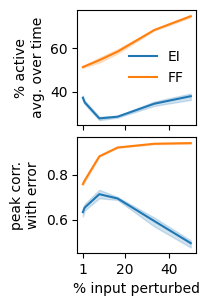

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(2, 3), sharex='all')
sns.lineplot(data=df_vpp, x='d', y='spar1', hue='model',legend='brief',  ax=ax[0])
sns.lineplot(data=df_vpp, x='d', y='corr', hue='model', legend=False, ax=ax[1])
ax[0].set(ylabel='% active\navg. over time')
ax[1].set(xlabel='% input perturbed', ylabel='peak corr.\nwith error', xticks=[1, 20, 40])
ax[0].legend(frameon=False)
fig.tight_layout(pad=0.5)
fig.savefig('svg/vary_pert.svg')

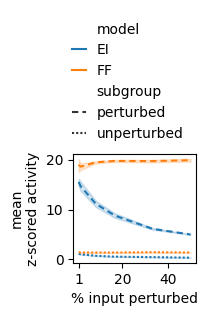

In [6]:
fig, ax = plt.subplots(2, figsize=(2, 3.1), sharex='all', height_ratios=[1, 1])
sns.lineplot(data=df_vpp_z, x='d', y='z', hue='model', style='subgroup', 
             dashes=[(3,2), (1,1)], ax=ax[1])
h, l = ax[1].get_legend_handles_labels()
ax[0].legend(handles=h, labels=l, loc='upper right', ncols=1, frameon=False, 
             handlelength=1, columnspacing=0.3)
ax[0].set_axis_off()
ax[1].get_legend().remove()
ax[1].set(xlabel='% input perturbed', ylabel='mean\nz-scored activity', xticks=[1, 20, 40])
fig.tight_layout(pad=0.5)
# fig.savefig('sparse2.svg')

In [33]:
df_vid = dict(tid=[], model=[], d=[], corr=[], spar1=[], spar2=[], spar3=[])

for i in range(1, 6):
    with open('results/vary_input_dim_%d.pkl' % i, 'rb') as f:
        # EIres, FFres, err, syl = pickle.load(f)
        EIcorrs, FFcorrs, EIpwcorrs, FFpwcorrs, EIsparsity, FFsparsity = pickle.load(f)
        df_vid['tid'].extend([i] * len(Ks_input) * 2)
        df_vid['model'].extend(['EI'] * len(Ks_input) + ['FF'] * len(Ks_input))
        df_vid['d'].extend(list(NE / Ks_input) * 2)
        df_vid['corr'].extend(list(map(lambda x: x[T_burn:].max(axis=1).mean(), EIcorrs)))
        df_vid['corr'].extend(list(map(lambda x: x[T_burn:].max(axis=1).mean(), FFcorrs)))
        
        for th in EIsparsity.keys():
            df_vid['spar%d'%th].extend(np.vstack(EIsparsity[th]).mean(axis=1) * 100)
            df_vid['spar%d'%th].extend(np.vstack(FFsparsity[th]).mean(axis=1) * 100)

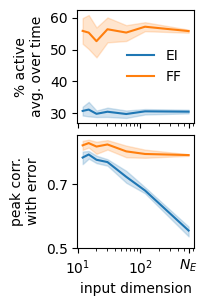

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(2, 3), sharex='all')
sns.lineplot(data=df_vid, x='d', y='spar1', hue='model',legend='brief',  ax=ax[0])
sns.lineplot(data=df_vid, x='d', y='corr', hue='model', legend=False, ax=ax[1])
ax[0].set(xscale='log', ylabel='% active\navg. over time')
ax[1].set(xlabel='input dimension', ylabel='peak corr.\nwith error', yticks=[0.7, 0.5],
          xticks=[10, 100, NE], xticklabels=['$10^1$', '$10^2$', '$N_E$'])
ax[0].legend(frameon=False)
fig.tight_layout(pad=0.5)
fig.savefig('svg/vary_input_dim.svg')

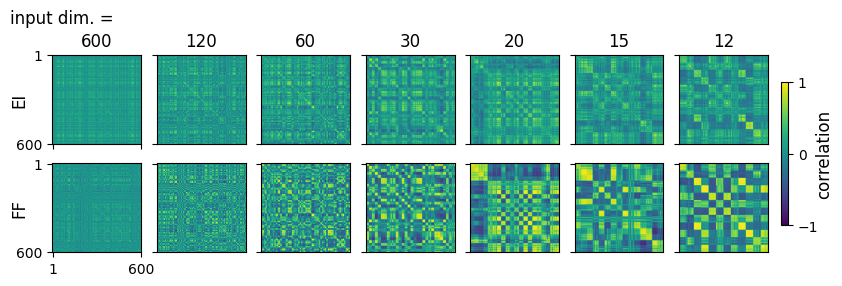

In [106]:
fig, ax = plt.subplots(2, len(EIpwcorrs), figsize=(9, 2.5), sharex='col', sharey='all')
for i, (p, q) in enumerate(zip(EIpwcorrs, FFpwcorrs)):
    im = ax[0,i].imshow(p, vmin=-1, vmax=1)
    ax[1,i].imshow(q, vmin=-1, vmax=1)
    ax[0,i].set_title('%d' % (NE / Ks_input[i]), fontsize=12)
    ax[0,i].set(xticks=[], yticks=[])
    ax[1,i].set(xticks=[], yticks=[])
ax[0,0].set_yticks([1,600])
ax[1,0].set(xticks=[1,600], yticks=[1,600])
ax[0,0].set_ylabel('EI', va='top', fontsize=12)
ax[1,0].set_ylabel('FF', va='top', fontsize=12)
fig.text(0.0, 1.08, 'input dim. = ', ha='left', va='top', fontsize=12)
fig.tight_layout(pad=0.05)
cax = fig.colorbar(im, ax=ax, shrink=0.7, pad=0.015, ticks=[-1, 0, 1])
cax.set_label('correlation', va='center', fontsize=12)
fig.savefig('svg/vary_input_dim_corrmat.svg', bbox_inches='tight')